# Introduction to Human Segmentation with U-Net


**U-Net** is a deep learning architecture designed specifically for semantic image segmentation tasks, where the goal is to predict a class for each pixel in an image. Initially developed for biomedical image segmentation, U-Net has become one of the most popular and effective models for segmentation in various domains, including human body segmentation.

**U-Net Architecture Overview**
U-Net’s architecture is composed of two primary parts:

**Encoder (Contracting Path)**: This part of the network is responsible for capturing the contextual information and abstract features from the input image. It is made up of a series of convolutional layers followed by max-pooling layers that progressively reduce the spatial dimensions of the image. Each convolution operation increases the number of feature maps, allowing the network to learn more complex features at each step.

**Decoder (Expansive Path)**: After the encoder extracts high-level features, the decoder aims to map these features back to the original spatial resolution of the input image. The decoder uses upsampling layers (like transposed convolutions or upconvolution) to increase the spatial dimensions, and these upsampled features are concatenated with the corresponding feature maps from the encoder. This process helps preserve fine-grained details, which are critical for accurate segmentation, especially at the pixel level.

The key innovation in the U-Net architecture is the use of skip connections that directly connect the encoder to the decoder. These connections pass feature maps from the encoder to the decoder, enabling the network to retain fine-grained spatial information. Without these connections, the model could lose important local details during the downsampling process.

U-Net preserve both high-level context (through the encoder) and low-level spatial information (through the skip connections)


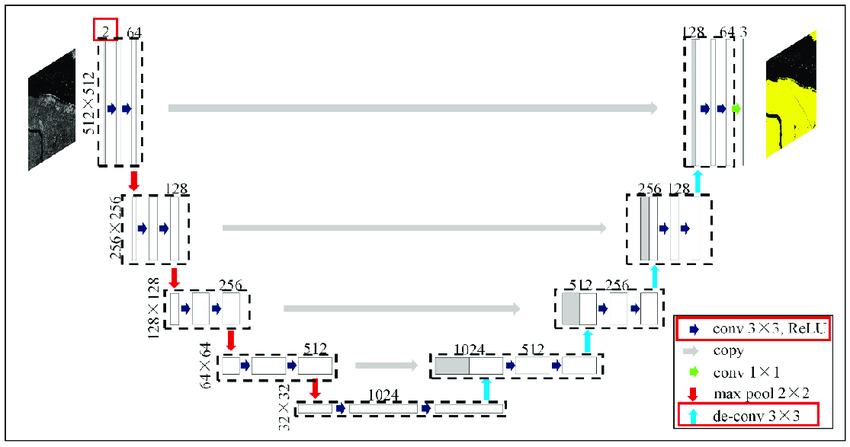
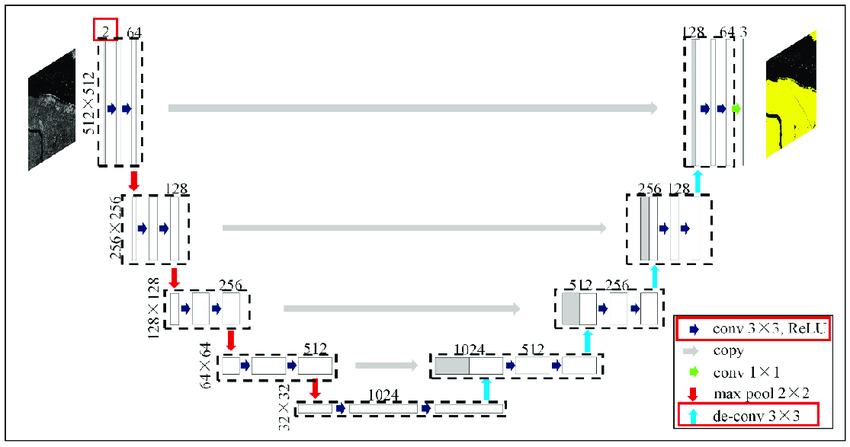

# Step 1: Import Necessary Libraries


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Step 2: Define Dataset Paths & Load a Sample Image


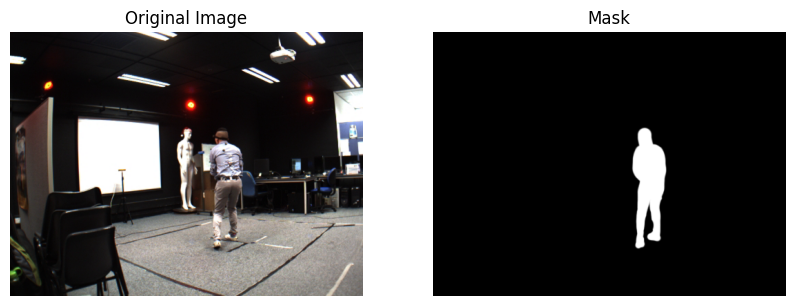

In [6]:
# Define dataset paths
img_path = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
mask_path = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'

# List all images
image_list = os.listdir(img_path)

# Choose a random image
img_name = random.choice(image_list)
img = plt.imread(os.path.join(img_path, img_name))
mask = plt.imread(os.path.join(mask_path, img_name))

# Display image and mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[1].imshow(mask)
axs[1].set_title("Mask")
for ax in axs:
    ax.axis('off')
plt.show()


# Step 3: Define a Custom PyTorch Dataset


In [8]:
class FullBodyDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.masks = labels
        #transform is a pipeline that defines all the preprocessing and augmentation steps applied to images and masks before training.
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load image
        image = self.images[index]
        image = cv2.imread(os.path.join(img_path, image), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, (300, 300))  # Resize image
        image /= 255.0  # Normalize to [0,1]

        # Load mask
        mask = self.masks[index]
        mask = cv2.imread(os.path.join(mask_path, mask), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (300, 300))  # Resize mask
        mask[mask > 0] = 1  # Convert mask to binary (0=background, 1=body)

        # Convert to tensor
        #A tensor is a multi-dimensional array similar to a NumPy array but optimized for deep learning and GPU acceleration. PyTorch uses tensors as the primary data structure for machine learning models.
        image = torch.as_tensor(image, dtype=torch.float32).numpy()
        mask = torch.as_tensor(mask, dtype=torch.long).numpy()

        # Apply augmentations
        if self.transform:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]

        return image, mask


The FullBodyDataset class inherits from PyTorch's Dataset class and is used to handle the loading and preprocessing of images and corresponding masks for segmentation tasks.

__init__(self, images, labels, transform):

Initializes the dataset with a list of image filenames (images), mask filenames (labels), and a transformation pipeline (transform).

The transform defines preprocessing and data augmentation steps to be applied to the images and masks.

__len__(self):

Returns the total number of samples (images) in the dataset.

__getitem__(self, index):

Loads an image and its corresponding mask using OpenCV.

The image is resized to 300x300, normalized to the range [0, 1], and converted to RGB format.

The mask is resized to 300x300 and converted to a binary format (0 for background, 1 for body).

Both the image and mask are converted to PyTorch tensors (multi-dimensional arrays) suitable for deep learning operations.

If any transformations or augmentations are specified (e.g., resizing, random flips, etc.), they are applied to the image and mask.


# Step 4: Split Data into Train and Validation Sets


In [11]:
# Extract image list
X = os.listdir(img_path)
y = X.copy()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 5: Define Transformations & DataLoaders


In [13]:
# Define transformations
transform = A.Compose([
    A.Resize(width=300, height=300),
    ToTensorV2()
    #Ensures all images have the same shape.
    #Converts data into a format compatible with PyTorch.
])

# Create dataset instances
train_dataset = FullBodyDataset(images=X_train, labels=y_train, transform=transform)
val_dataset = FullBodyDataset(images=X_val, labels=y_val, transform=transform)

# Define DataLoaders
BATCH_SIZE = 8
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


Batch processing improves training efficiency. this means 8 images processed in one step

Shuffling prevents the model from memorizing the order of images.

Parallel processing (num_workers) speeds up data loading.

---


# Step 6: Load Pre-trained U-Net Model


In [14]:
# Use a pre-trained U-Net model for segmentation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:01<00:00, 105MB/s]  


# Step 7: Train the Model


In [15]:
EPOCHS = 5  # Number of epochs
# An epoch is one full pass through the entire dataset.
for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for step, (images, labels) in enumerate(train_data_loader):
        images = images.to(device).float()
        labels = labels.to(device).long()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f'Epoch {epoch}/{EPOCHS} - Loss: {sum(losses)/len(losses):.4f}')
    
    # Save model checkpoint
    torch.save(model.state_dict(), 'best.pth')


Epoch 1/5 - Loss: 0.2458
Epoch 2/5 - Loss: 0.0740
Epoch 3/5 - Loss: 0.0586
Epoch 4/5 - Loss: 0.0510
Epoch 5/5 - Loss: 0.0466


# Step 8: Load Trained Model for Inference


In [17]:
# Load the trained model
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=False, scale=0.5)
model.load_state_dict(torch.load("best.pth"))
model = model.to(device)
model.eval()


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
<ipython-input-17-86f18bc6dfe7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

This function loads a pre-trained U-Net model for image segmentation from a GitHub repository, initializes it with random weights, and then loads the trained weights from a saved checkpoint (best.pth). The model is moved to the appropriate device (GPU or CPU) for efficient computation, depending on the availability of hardware. Finally, the model is set to evaluation mode (model.eval()), which ensures that layers like dropout and batch normalization operate in inference mode, providing consistent behavior during testing or prediction. This process prepares the model for making predictions on new data using the learned parameters from the training phase.

# Step 9: Visualize Predictions


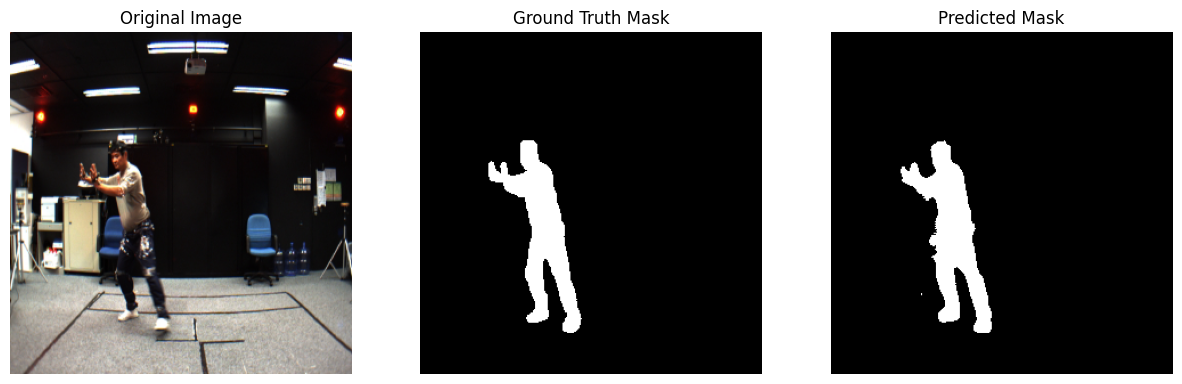

In [18]:
for batch, (img, label) in enumerate(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        pred = torch.argmax(model(img[0].unsqueeze(0)), dim=1).squeeze(0).cpu().numpy()

    # Display the results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(torch.permute(img[0].cpu(), (1, 2, 0)))
    axs[0].set_title('Original Image')

    axs[1].imshow(label[0].cpu().numpy(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')

    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')
    plt.show()

    # Stop after showing the first batch
    break


This code evaluates a trained U-Net segmentation model on a validation dataset and visualizes the results. For each batch in the validation data loader, it performs the following steps:

Moves the input image to the appropriate device (GPU or CPU).

Makes predictions using the model without calculating gradients (to save memory and speed up inference).

Displays the original image, ground truth mask, and predicted mask in a side-by-side plot.

Turns off the axis labels for cleaner visualization.

Stops after displaying the results for the first batch to allow for quick inspection before continuing with the rest of the validation.

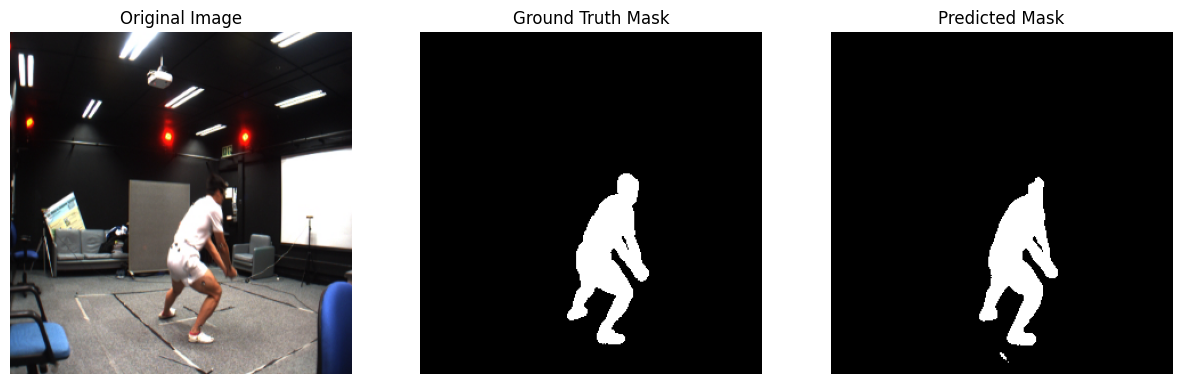

In [24]:
for batch, (img, label) in enumerate(val_data_loader):
    img = img.to(device)
    
    # Choose another image in the batch (e.g., img[1] for the second image)
    with torch.no_grad():
        pred = torch.argmax(model(img[2].unsqueeze(0)), dim=1).squeeze(0).cpu().numpy()  # Use img[1]

    # Display the results for the second image in the batch (img[1])
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(torch.permute(img[2].cpu(), (1, 2, 0)))  # Show the second image in the batch
    axs[0].set_title('Original Image')

    axs[1].imshow(label[2].cpu().numpy(), cmap='gray')  # Ground truth mask for the second image
    axs[1].set_title('Ground Truth Mask')

    axs[2].imshow(pred, cmap='gray')  # Predicted mask for the second image
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')

    plt.show()

    # Stop after showing the first batch
    break


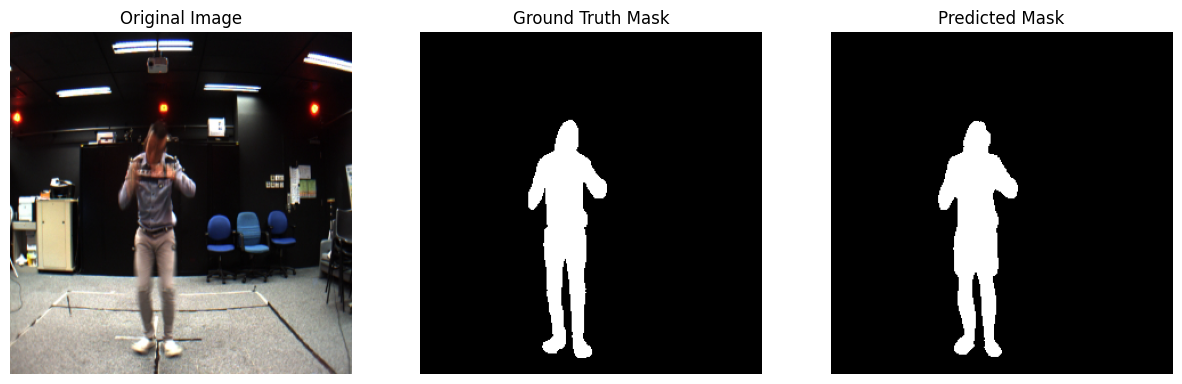

In [25]:
for batch, (img, label) in enumerate(val_data_loader):
    img = img.to(device)
    
    # Choose another image in the batch (e.g., img[1] for the second image)
    with torch.no_grad():
        pred = torch.argmax(model(img[7].unsqueeze(0)), dim=1).squeeze(0).cpu().numpy()  # Use img[1]

    # Display the results for the second image in the batch (img[1])
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(torch.permute(img[7].cpu(), (1, 2, 0)))  # Show the second image in the batch
    axs[0].set_title('Original Image')

    axs[1].imshow(label[7].cpu().numpy(), cmap='gray')  # Ground truth mask for the second image
    axs[1].set_title('Ground Truth Mask')

    axs[2].imshow(pred, cmap='gray')  # Predicted mask for the second image
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')

    plt.show()

    # Stop after showing the first batch
    break
